# Implementation of Kruskal's algorithm in python using stock prices

## Introduction

In this notebook, I hope to walk you through the implementation and usage of Kruskal’s algorithm following the methodology of Mantegna (1999). Kruskal’s algorithm is a greedy approach for finding a minimum spanning tree, where a minimum spanning trees connects all nodes of a tree with a minimum total weight of the edges. An example where this procedure is used, is in deciding the shortest path for a telephone network. One of the advantages is the lower cost for the cable company. Today, we will apply Kruskal’s algorithm on 50 stocks.

In [3]:
#import dependencies
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from kruskal import correlation, distance, MST

## Data
In contrary to most examples of financial algorithms, we will be using the 50 largest Dutch stocks instead. To be more precise, the previous year of daily adjusted close prices. In order to download this data, we will be using yfinance.

In [4]:
#Import data
with open('tickers.txt', 'r') as file:
    tickers =  file.read()
data_raw = yf.download(tickers, period='1y')
data = data_raw['Adj Close'] #adjusted close data of 1yr of 50 dutch stocks with daily interval
data.head()

[*********************100%***********************]  50 of 50 completed


,AALB.AS,ABN.AS,ACCEL.AS,AD.AS,ADYEN.AS,AGN.AS,AJAX.AS,AKZA.AS,ALFEN.AS,AMG.AS,...,RDSA.AS,REN.AS,SBMO.AS,TKWY.AS,TWEKA.AS,UNA.AS,URW.AS,VPK.AS,WHA.AS,WKL.AS
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-17,32.682949,16.743856,24.700001,20.127090,686.000000,4.052221,17.783653,81.090714,10.60,26.921206,...,26.599607,21.314192,17.032396,81.300003,51.308296,52.380737,104.225754,41.982704,18.428133,64.205460
2019-07-18,32.298000,16.743856,24.549999,19.663622,698.000000,4.046880,17.981251,80.302292,10.60,26.394295,...,26.397383,21.030523,16.848745,80.750000,50.115082,52.438816,103.612419,41.796852,18.411530,63.733940
2019-07-19,32.711113,16.622835,24.650000,19.682934,694.599976,4.058452,17.783653,80.302292,10.60,26.618721,...,26.585497,21.157682,16.867582,80.000000,50.449181,52.051605,104.675529,42.021832,18.527742,64.028641
2019-07-22,32.260445,16.212234,24.799999,19.851904,701.200012,4.037977,17.882452,79.835075,10.54,26.872417,...,26.754801,21.138123,16.990017,80.900002,51.117382,52.206490,103.039978,42.002266,18.328520,64.264404
2019-07-23,33.067894,16.268421,24.500000,19.784315,708.400024,4.096731,17.783653,80.302292,10.60,27.750603,...,26.919405,21.226156,16.952345,80.349998,51.928772,52.574348,105.125305,42.148994,18.627356,65.089561


## Constructing our distance matrix
In order to make use of Kruskal’s algorithm, we need a distance matrix which we will construct from a correlation matrix, using logarithmic returns as described by G. Marti et al. (2019):
1.	Compute logarithmic returns:  

$$ r _i (t) = \log(P _i(t)) - \log(P _i(t-1)) $$

2.	Construct our correlation matrix using Pearson’s cross correlation coefficients:  

$$ \rho _{ij} = \frac{\langle r _i r _j\rangle - \langle r _i\rangle \langle r _j \rangle}{\sqrt{(\langle r^2 _i \rangle - \langle r _i \rangle ^2)(\langle r^2 _j \rangle - \langle r _j \rangle ^2)}} $$

3.	Calculate the corresponding distance matrix:  

$$ d _{ij} = \sqrt{2(1-\rho _{ij})} $$
        
Based on our correlation matrix, we can get a first impression of the underlying hierarchy of our stocks.  

Our correlation function has the option 'reverse', which gives us the ability to use a dataframe as input of which the index is in descending order. By default, reverse is False, and a dataframe with an ascending index (as above) should be given as input.

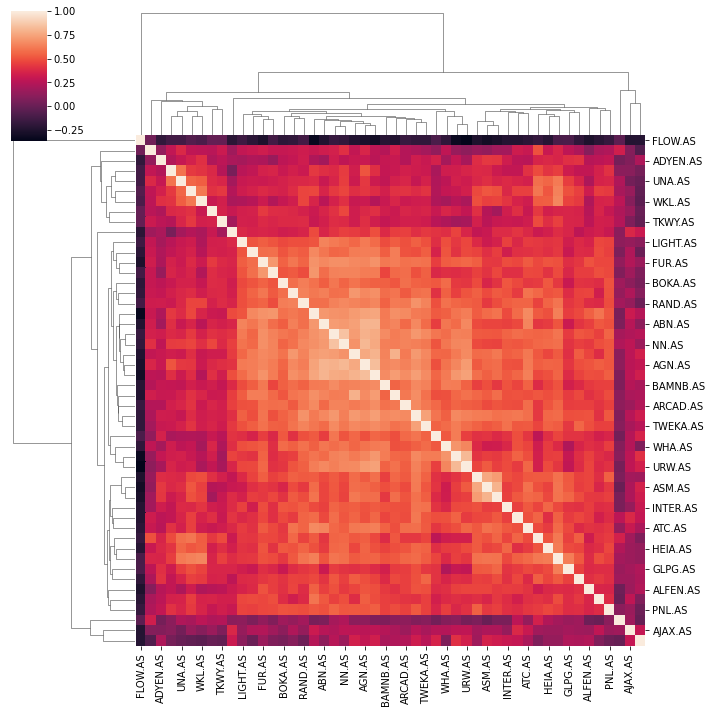

In [5]:
#Correlation matrix
corr = correlation(data, reverse=False)
cluster = sns.clustermap(corr)
plt.show()

In [7]:
#Distance
dis = distance(corr)
dis.head()

,AALB.AS,ABN.AS,ACCEL.AS,AD.AS,ADYEN.AS,AGN.AS,AJAX.AS,AKZA.AS,ALFEN.AS,AMG.AS,...,RDSA.AS,REN.AS,SBMO.AS,TKWY.AS,TWEKA.AS,UNA.AS,URW.AS,VPK.AS,WHA.AS,WKL.AS
AALB.AS,0.000000,0.824361,1.083317,1.249545,1.153666,0.787773,1.220647,0.879423,0.988900,1.004292,...,0.874211,0.921559,0.996231,1.145482,0.719225,1.181277,0.844230,1.350317,0.952188,1.156748
ABN.AS,0.824361,0.000000,0.974425,1.154938,1.271491,0.622010,1.224053,1.015420,1.042092,0.881850,...,0.759659,0.988607,0.915019,1.144614,0.917376,1.174794,0.821274,1.360492,0.884246,1.212807
ACCEL.AS,1.083317,0.974425,0.000000,1.255808,1.207514,0.956959,1.198954,1.145807,1.123626,1.015210,...,0.891890,1.008130,1.004324,1.144432,1.043999,1.130932,1.105865,1.407823,1.109501,1.133480
AD.AS,1.249545,1.154938,1.255808,0.000000,1.308117,1.123144,1.345474,1.158443,1.342447,1.170957,...,1.178709,1.123599,1.180423,1.167569,1.268542,1.112220,1.323670,1.148386,1.201683,1.206993
ADYEN.AS,1.153666,1.271491,1.207514,1.308117,0.000000,1.175347,1.351226,1.209961,1.219875,1.239915,...,1.244575,1.127796,1.299510,1.210102,1.176261,1.181839,1.259833,1.380488,1.266717,1.090345


## Kruskal's algorithm
Now, we are ready to apply Kruskal’s algorithm, which goes as follows:
1.	Start with a fully disconnected graph
2.	In order of increasing distance between stocks, if the two corresponding stocks are not already connected, add an edge in the graph.  
( a more detailed procedure can be found in the paper of G. Marti et al. (2019) ) 

Finally, we have arrived at our main result:

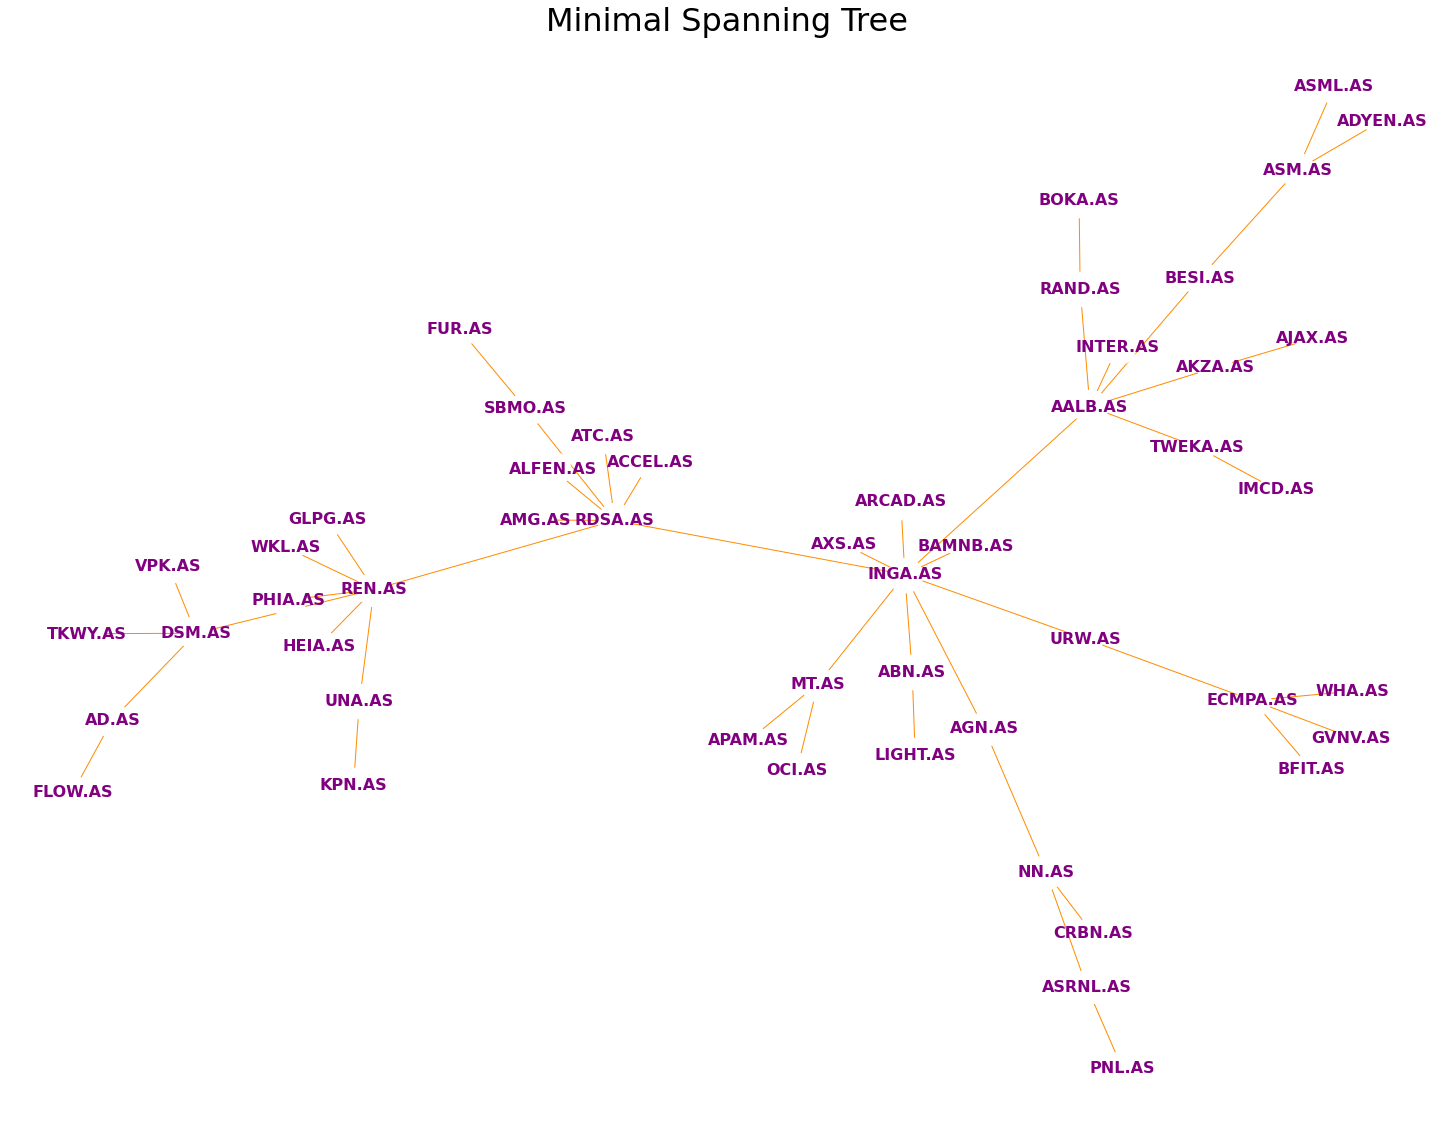

In [9]:
#MST
G = MST(dis)
fig = plt.figure(figsize=(20,15))
nx.draw_spring(G, with_labels=True, node_color= 'white', node_size= 1200, font_size = 16, font_color='purple', font_weight='bold', 
        edge_color = 'darkorange')
plt.title('Minimal Spanning Tree', size=32)
plt.draw()

## Conclusion
So, in this notebook we have constructed a distance matrix for the 50 most traded Dutch stocks and have applied Kruskal’s algorithm. The result can be used to identify and cluster stocks.

For further reading, I recommend that you check out:  
G. Marti et al., A review of two decades of correlations, hierarchies, networks and clustering
in financial markets (2019) 1-2.   

## References:
 R. N. Mantegna, Hierarchical structure in financial markets, The European Physical Journal B-Condensed Matter and Complex Systems 11 (1999)
193–197.   
G. Marti et al., A review of two decades of correlations, hierarchies, networks and clustering
in financial markets (2019) 1-2.   

By: Robert Smolders